In [114]:
import neuralfoil as nf
import aerosandbox.numpy as np
import aerosandbox as asb
import aerosandbox.tools.pretty_plots as p
import matplotlib.pyplot as plt
import casadi as ca

In [115]:
coor_airfoil = asb.Airfoil("NACA6412")

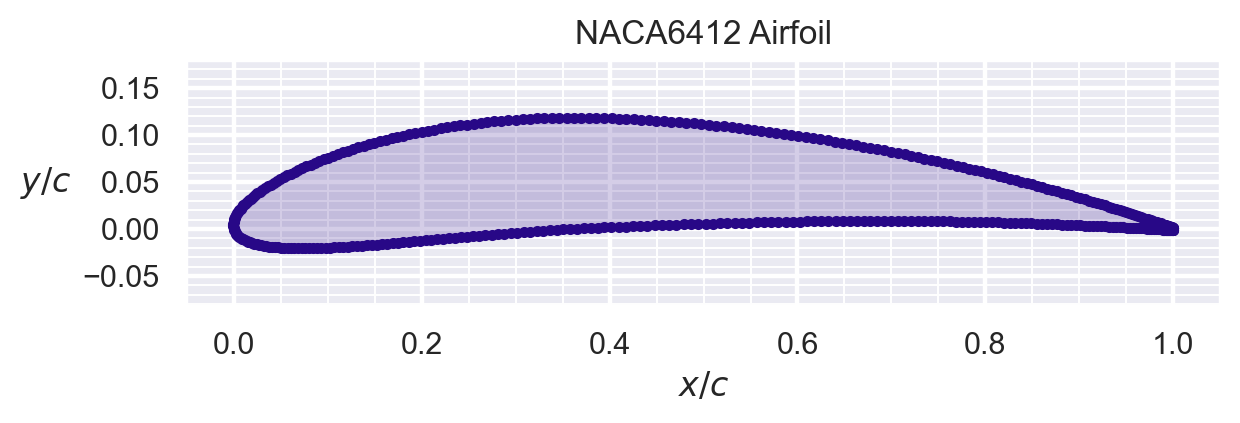

In [116]:
fig, ax = plt.subplots(figsize=(6,2))
coor_airfoil.draw()

# Airfoil shape optimization
Multipoint optimization.

Minimize $C_{D}$ at a given Reynolds number $Re_{c} = 5e5$ by changing the airfoil's shape and angle of attack $\alpha$. We can also maintain other constraints like specifying $C_{L}, C_{M}$, trailing-edge angle, leading-edge angle, etc.

In [117]:
# convert xy-coordinate airfoil to KulfanAirfoil with CST parameterization
# need KulfanAirfoil to do optimization
kulfan_airfoil = coor_airfoil.to_kulfan_airfoil()
print(kulfan_airfoil.kulfan_parameters)

{'lower_weights': array([-1.72831249e-01, -7.31102470e-02, -1.06376274e-05,  4.68445426e-02,
       -4.80557835e-02,  9.16088531e-02,  1.99100831e-02,  6.50767126e-02]), 'upper_weights': array([0.18418411, 0.23707142, 0.34097835, 0.30185217, 0.28409632,
       0.34191236, 0.31573228, 0.34792275]), 'leading_edge_weight': 0.18132166489471696, 'TE_thickness': 0.002602136429121958}


In [118]:
# initial guess airfoil = s1223
# CL_multipoint_targets = np.array([1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
CL_multipoint_targets = np.arange(1.6, 2.8, 0.2)
print(len(CL_multipoint_targets))
CL_multipoint_weights = np.array([5, 6, 7, 8, 9, 10])


6


In [119]:
Re = 5e5 * (CL_multipoint_targets / 1.25) ** -0.5 # reynolds numbers for each target
# driving at around 50 mph = 22.4 m/s
mach = 0.065

In [120]:
initial_guess_airfoil = asb.KulfanAirfoil("NACA6412")
initial_guess_airfoil.name = "initial guess"

In [121]:
# Setting up our optimizer, initial guesses, bounds for guesses
opti = asb.Opti()

optimized_airfoil = asb.KulfanAirfoil(
    name = "Optimized",
    lower_weights=opti.variable( # weights for the lower surface of airfoil
        init_guess = initial_guess_airfoil.lower_weights,
        lower_bound = -0.25,
        upper_bound = 0.5,
    ),
    upper_weights=opti.variable(
        init_guess = initial_guess_airfoil.upper_weights,
        lower_bound = -0.25,
        upper_bound = 0.5,
    ),
    leading_edge_weight=opti.variable(
        init_guess = initial_guess_airfoil.leading_edge_weight,
        lower_bound = 1,
        upper_bound = 1
    ),
    TE_thickness=0,
)

alpha = opti.variable(
    init_guess = np.degrees(CL_multipoint_targets/(2*np.pi)),
    lower_bound = -5,
    upper_bound = 18
)

In [122]:
aero = optimized_airfoil.get_aero_from_neuralfoil(
    alpha=alpha,
    Re=Re,
    mach=mach,
)

In [123]:
# IGNORE ALL OF THIS, NEED TO BE USING AEROSANDBOX.NUMPY NOT REGULAR
## chatgpt says this is equivalent to np.diff (which doesn't work for CasAdi)
## i'm going to let chat take the wheel on this one and hope it works out
## ok it didn't work out, I commented everything out, I'm going to just take that constraint out and hope for the best
## constraint: np.diff(alpha) > 0
# diff_alpha = alpha[1:] - alpha[:-1]
# ca_diff = ca.Function("ca_diff", [alpha], [diff_alpha])

In [124]:
# setting up our constraints
# must optimize to within these bounds so there aren't crazy optimizations produced
# should change these constraints from the default
opti.subject_to([
    aero["analysis_confidence"] > 0.90,
    aero["CL"] == CL_multipoint_targets,
    aero["CM"] >= -0.133, # pitching moment
    np.diff(alpha) > 0,
    optimized_airfoil.local_thickness(x_over_c=0.33) >= 0.128,
    optimized_airfoil.local_thickness(x_over_c=0.90) >= 0.014,
    optimized_airfoil.TE_angle() >= 6.25,
    optimized_airfoil.lower_weights[0] < -0.05,
    optimized_airfoil.upper_weights[0] > 0.05,
    optimized_airfoil.local_thickness() > 0
])

[MX(fabs(opti7_lam_g_9)),
 MX(fabs(opti7_lam_g_10)),
 MX(fabs(opti7_lam_g_11)),
 MX(fabs(opti7_lam_g_12)),
 MX(fabs(opti7_lam_g_13)),
 MX(fabs(opti7_lam_g_14)),
 MX(fabs(opti7_lam_g_15)),
 MX(fabs(opti7_lam_g_16)),
 MX(fabs(opti7_lam_g_17)),
 MX(fabs(opti7_lam_g_18))]

In [125]:
# what is wiggliness?? unserious name
get_wiggliness = lambda af: sum([
    np.sum(np.diff(np.diff(array)) ** 2)
    for array in [af.lower_weights, af.upper_weights]
])

In [126]:
opti.subject_to(
    get_wiggliness(optimized_airfoil) < 2 * get_wiggliness(initial_guess_airfoil)
)

MX(fabs(opti7_lam_g_19))

In [127]:
# doing important work here
opti.minimize(np.mean(aero["CD"] * CL_multipoint_weights))

In [128]:
sol = opti.solve(
    behavior_on_failure="return_last",
    options={
        "ipopt.mu_strategy": 'monotone',
        "ipopt.start_with_resto": 'yes'
    }
)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      108
Number of nonzeros in inequality constraint Jacobian.:     2043
Number of nonzeros in Lagrangian Hessian.............:      261

Total number of variables............................:       23
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number of inequality constraints...............:      170
        inequality constraints with only lower bounds:      145
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       25

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7537848e+00 4.52e+00 1.15e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

C:\Users\amcpo\anaconda3\Lib\site-packages\aerosandbox\optimization\opti.py:728: UserWarning: Optimization failed. Returning last solution.
  warnings.warn("Optimization failed. Returning last solution.")


In [129]:
optimized_airfoil = sol(optimized_airfoil)
aero = sol(aero)

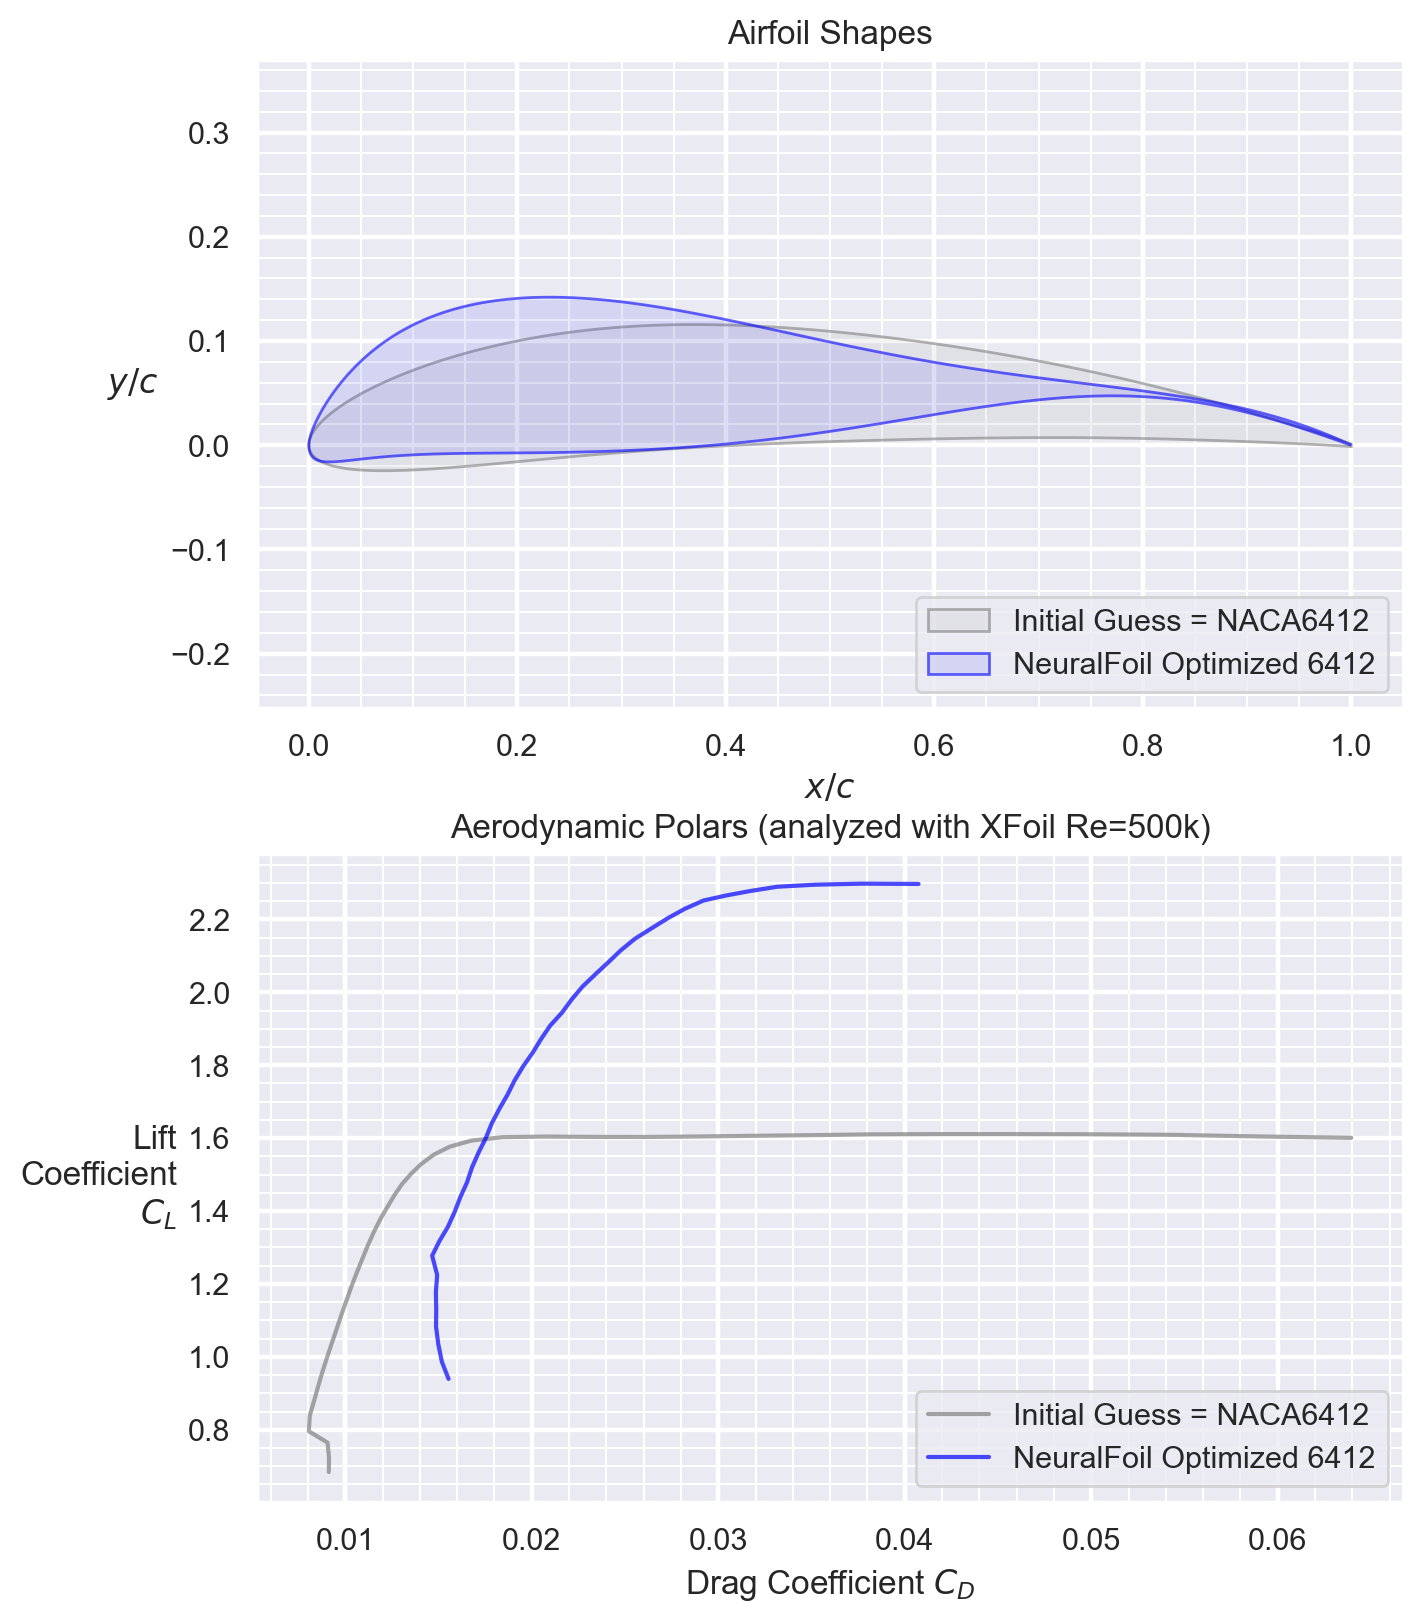

In [131]:
fig, ax = plt.subplots(2, 1, figsize=(7,8))

airfoils = [initial_guess_airfoil, optimized_airfoil]
colors = ['gray', 'blue']
names = ['Initial Guess = NACA6412', 'NeuralFoil Optimized 6412']

for af, color, name in zip(airfoils, colors, names):
    color = p.adjust_lightness(color, 1)
    ax[0].fill(
        af.x(), af.y(),
        facecolor=(*color, 0.09),
        edgecolor=(*color, 0.6),
        linewidth=1,
        label=name
    )

    # calls to XFoil to calculate stuff for the second graph
    aero = asb.XFoil(
        airfoil=af,
        Re=5e5,
        mach=mach,
        timeout=30,
    ).alpha(np.linspace(0, 15, 41), start_at=5)

    ax[1].plot(
        aero['CD'], aero['CL'], color=color, alpha=0.7,
        label = name
    )

ax[0].legend(fontsize=11, loc="lower right", ncol=1)
ax[0].set_title("Airfoil Shapes")
ax[0].set_xlabel("$x/c$")
ax[0].set_ylabel("$y/c$")
ax[0].axis('equal')

ax[1].legend(fontsize=11, loc="lower right", ncol=1)
ax[1].set_title("Aerodynamic Polars (analyzed with XFoil Re=500k)")
ax[1].set_xlabel("Drag Coefficient $C_D$")
ax[1].set_ylabel("Lift\nCoefficient\n$C_L$")
# p.show_plot("Comparison of NeuralFoil-optimized Airfoil and Initial S1223 Airfoil", legend=False)
p.show_plot()